<a href="https://colab.research.google.com/github/Jay4BioPZ/dlfb-course/blob/main/notebooks/chapter_2_proteins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

To run this notebook on Colab, a few setup steps are required. Follow along step by step:

1. **Clone the `dlfb` library**  
   First, clone the repository that contains the `dlfb` library.

In [2]:
%cd /content
!rm -rf ./dlfb-clone/
!git clone "https://github.com/deep-learning-for-biology/dlfb.git" dlfb-clone --branch main
%cd dlfb-clone

/content
Cloning into 'dlfb-clone'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 121 (delta 19), reused 111 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (121/121), 62.31 KiB | 6.92 MiB/s, done.
Resolving deltas: 100% (19/19), done.
/content/dlfb-clone


2. **Install dependencies**  
   Once the library is cloned, install the required dependencies.

In [3]:
%%bash
curl -LsSf https://astral.sh/uv/install.sh | sh && \
export PATH="/root/.local/bin:${PATH}" && \
uv pip compile ./requirements/{base,dlfb,proteins,gpu}.txt \
  --color never \
  --constraint ./requirements/constraints.txt | \
uv pip install -r - --system

no checksums to verify
installing to /usr/local/bin
  uv
  uvx
everything's installed!


downloading uv 0.9.9 x86_64-unknown-linux-gnu
Resolved 141 packages in 440ms
Using Python 3.12.12 environment at: /usr
Resolved 141 packages in 374ms
Prepared 1 package in 1.43s
Uninstalled 1 package in 0.69ms
Installed 1 package in 3ms
 ~ dlfb==0.1.1 (from file:///content/dlfb-clone)


3. **Providion the datasets**  
   You’ll then need to access and download the necessary datasets for this chapter.

In [4]:
# NOTE: exclude models with '--no-models' flag
!dlfb-provision --chapter proteins

Files Downloaded: 100% 22/22 [00:00<00:00, 75.37file/s]


4. **Load the `dlfb` package**  
   Finally, load the `dlfb` package.  
   - ⚠️ Note: Loading can sometimes be finicky. If you encounter issues, simply **restart the runtime**. All previously downloaded data and installed packages will persist, so you can re-run the load step without repeating everything.

In [5]:
# Toggle JAX_DISABLE_JIT to True for easier debugging
%env JAX_DISABLE_JIT=False

try:
  import dlfb
except ImportError as exc:
  # NOTE: Packages installed in editable mode are not immediately
  #       recognized by Colab (https://stackoverflow.com/a/63312333).
  import site
  site.main()
  import dlfb

from dlfb.utils.display import display

env: JAX_DISABLE_JIT=False


# 2. Learning the Language of Proteins

## 2.1. Biology Primer
### 2.1.1. Protein Structure
### 2.1.2. Protein Function
### 2.1.3. Predicting Protein Function


## 2.2. Machine Learning Primer
### 2.2.1. Large Language Models
### 2.2.2. Embeddings
### 2.2.3. Pretraining and Fine-tuning


## 2.3. Representations of Proteins and Protein LMs


In [6]:
import py3Dmol
import requests


def fetch_protein_structure(pdb_id: str) -> str:
  """Grab a PDB protein structure from the RCSB Protein Data Bank."""
  url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
  response = requests.get(url)
  return response.text


# The Protein Data Bank (PDB) is the main database of protein structures.
# Each structure has a unique 4-character PDB ID. Below are a few examples.
protein_to_pdb = {
  "insulin": "3I40",  # Human insulin – regulates glucose uptake.
  "collagen": "1BKV",  # Human collagen – provides structural support.
  "proteasome": "1YAR",  # Archaebacterial proteasome – degrades proteins.
}

protein = "collagen"  # @param ["insulin", "collagen", "proteasome"]
pdb_structure = fetch_protein_structure(pdb_id=protein_to_pdb[protein])

pdbview = py3Dmol.view(width=400, height=300)
pdbview.addModel(pdb_structure, "pdb")
pdbview.setStyle({"cartoon": {"color": "spectrum"}})
pdbview.zoomTo()
pdbview.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### 2.3.1. Numerical Representation of a Protein


In [7]:
# Precursor insulin protein sequence (processed into two protein chains).
insulin_sequence = (
  "MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGG"
  "GPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN"
)
print(f"Length of the insulin protein precursor: {len(insulin_sequence)}.")

Length of the insulin protein precursor: 110.


### 2.3.2. One-Hot Encoding of a Protein Sequence


In [8]:
from dlfb.utils.display import print_short_dict

# fmt: off
amino_acids = [
  "R", "H", "K", "D", "E", "S", "T", "N", "Q", "G", "P", "C", "A", "V", "I",
  "L", "M", "F", "Y", "W",
]
# fmt: on

amino_acid_to_index = {
  amino_acid: index for index, amino_acid in enumerate(amino_acids)
}

print_short_dict(amino_acid_to_index)

{'R': 0, 'H': 1, 'K': 2, 'D': 3, 'E': 4, 'S': 5, 'T': 6, 'N': 7, 'Q': 8, 'G': 9}
…(+10 more entries)


In [9]:
# Methionine, alanine, leucine, tryptophan, methionine.
tiny_protein = ["M", "A", "L", "W", "M"]

tiny_protein_indices = [
  amino_acid_to_index[amino_acid] for amino_acid in tiny_protein
]

tiny_protein_indices

[16, 12, 15, 19, 16]

In [10]:
import jax

one_hot_encoded_sequence = jax.nn.one_hot(
  x=tiny_protein_indices, num_classes=len(amino_acids)
)

print(one_hot_encoded_sequence)
# each row: encoding of aa.
# each column: one aa.

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


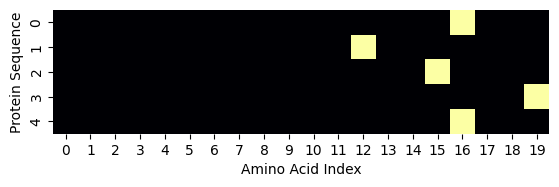

In [11]:
import seaborn as sns

fig = sns.heatmap(
  one_hot_encoded_sequence, square=True, cbar=False, cmap="inferno"
)
fig.set(xlabel="Amino Acid Index", ylabel="Protein Sequence");

### 2.3.3. Learned Embeddings of Amino Acids


In [1]:
from transformers import AutoTokenizer, EsmModel

# Model checkpoint name taken from this GitHub README:
# https://github.com/facebookresearch/esm#available-models-and-datasets-
model_checkpoint = "facebook/esm2_t33_650M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = EsmModel.from_pretrained(model_checkpoint)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Have problems here with numpy package loading. Version 1.26 was installed to successfully load transformers. Restart kernel after numpy installment, and then immediately load Transformer package. After that, rerun all the remaining code blocks above.

In [13]:
# # Install a compatible NumPy version to resolve conflicts.
!pip install numpy==1.26.4 --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 64.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.2
    Uninstalling numpy-2.1.2:
      Successfully uninstalled numpy-2.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
yfinance 0.2.66 requires requests>=2.31, but you have requests 2.28.1 which is incompatible.
gradio 5.49.1 requires typer<1.0,>=0.12, but you have typer 0.7.0 which is incompatible.
db-dtypes 1.4.4 requires packaging>=24.2.0, but you have packaging 24.1 which is incompatible.
umap-learn 0.5.9.pos

In [12]:
vocab_to_index = tokenizer.get_vocab()
print_short_dict(vocab_to_index)

{'<cls>': 0, '<pad>': 1, '<eos>': 2, '<unk>': 3, 'L': 4, 'A': 5, 'G': 6, 'V': 7,
'S': 8, 'E': 9}
…(+23 more entries)


In [13]:
vocab_to_index

{'<cls>': 0,
 '<pad>': 1,
 '<eos>': 2,
 '<unk>': 3,
 'L': 4,
 'A': 5,
 'G': 6,
 'V': 7,
 'S': 8,
 'E': 9,
 'R': 10,
 'T': 11,
 'I': 12,
 'D': 13,
 'P': 14,
 'K': 15,
 'Q': 16,
 'N': 17,
 'F': 18,
 'Y': 19,
 'M': 20,
 'H': 21,
 'W': 22,
 'C': 23,
 'X': 24,
 'B': 25,
 'U': 26,
 'Z': 27,
 'O': 28,
 '.': 29,
 '-': 30,
 '<null_1>': 31,
 '<mask>': 32}

In [14]:
tokenized_tiny_protein = tokenizer("MALWM")["input_ids"]
tokenized_tiny_protein

[0, 20, 5, 4, 22, 20, 2]

In [15]:
# drop the cls and eos token when displaying
tokenized_tiny_protein[1:-1]

[20, 5, 4, 22, 20]

Each of the 33 possible tokens is embedded into a 1280-dimensional space

In [16]:
token_embeddings = model.get_input_embeddings().weight.detach().numpy()
token_embeddings.shape

(33, 1280)

In [17]:
import pandas as pd
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(token_embeddings)
embeddings_tsne_df = pd.DataFrame(
  embeddings_tsne, columns=["first_dim", "second_dim"]
)
embeddings_tsne_df.shape

(33, 2)

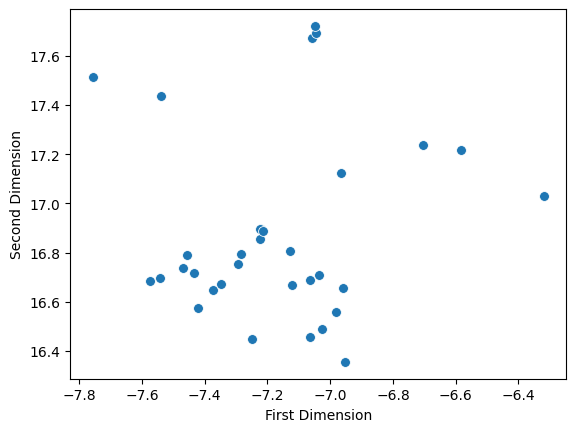

In [18]:
fig = sns.scatterplot(
  data=embeddings_tsne_df, x="first_dim", y="second_dim", s=50
)
fig.set_xlabel("First Dimension")
fig.set_ylabel("Second Dimension");

Sanity check, add annotations onto the plot

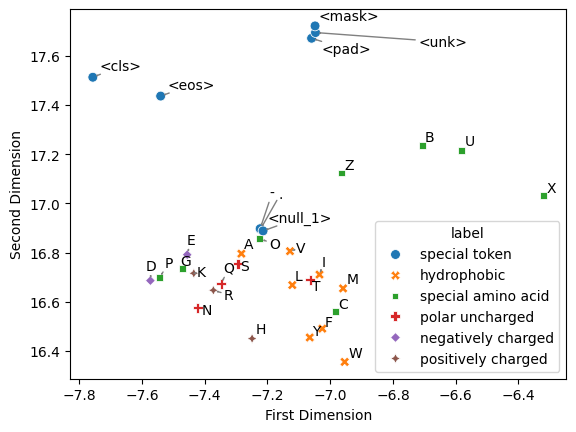

In [19]:
from adjustText import adjust_text

embeddings_tsne_df["token"] = list(vocab_to_index.keys())

token_annotation = {
  "hydrophobic": ["A", "F", "I", "L", "M", "V", "W", "Y"],
  "polar uncharged": ["N", "Q", "S", "T"],
  "negatively charged": ["D", "E"],
  "positively charged": ["H", "K", "R"],
  "special amino acid": ["B", "C", "G", "O", "P", "U", "X", "Z"],
  "special token": [
    "-",
    ".",
    "<cls>",
    "<eos>",
    "<mask>",
    "<null_1>",
    "<pad>",
    "<unk>",
  ],
}

embeddings_tsne_df["label"] = embeddings_tsne_df["token"].map(
  {t: label for label, tokens in token_annotation.items() for t in tokens}
)

fig = sns.scatterplot(
  data=embeddings_tsne_df,
  x="first_dim",
  y="second_dim",
  hue="label",
  style="label",
  s=50,
)
fig.set_xlabel("First Dimension")
fig.set_ylabel("Second Dimension")
texts = [
  fig.text(point["first_dim"], point["second_dim"], point["token"])
  for _, point in embeddings_tsne_df.iterrows()
]
adjust_text(
  texts, expand=(1.5, 1.5), arrowprops=dict(arrowstyle="->", color="grey")
);

### 2.3.4. The ESM2 Protein Language Model


In [20]:
insulin_sequence = (
  "MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGG"
  "GPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN"
)

masked_insulin_sequence = (
  # Let's mask the `L` amino acid in the 29th position (0-based indexing):
  #       ...LALLALWGPDPAAAFVNQH  L   CGSHLVEALYLVCGERGFF...
  "MALWMRLLPLLALLALWGPDPAAAFVNQH<mask>CGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGG"
  "GPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN"
)

# Tokenize the masked insulin sequence.
masked_inputs = tokenizer(masked_insulin_sequence)["input_ids"]

# Check that we indeed have a <mask> token in the place that we expect it. Note
# that the tokenizer adds a <cls> token to the start of the sequence, so we in
# fact expect the <mask> token at position 30 (not 29).
# assert check if the condition is true
assert masked_inputs[30] == vocab_to_index["<mask>"]

The <mask> token tells the model to predict the amino acid at that position. To do this, we load the full language model, EsmForMaskedLM, which includes the language prediction head.

In [21]:
from transformers import EsmForMaskedLM

# Model checkpoint name taken from this GitHub README:
# https://github.com/facebookresearch/esm#available-models-and-datasets-
model_checkpoint = "facebook/esm2_t30_150M_UR50D" # a smaller model with 640-dimensional embeddings
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
masked_lm_model = EsmForMaskedLM.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/595M [00:00<?, ?B/s]

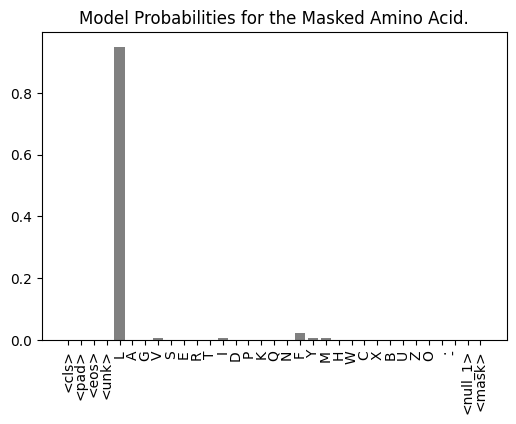

In [22]:
import matplotlib.pyplot as plt

model_outputs = masked_lm_model(
  **tokenizer(text=masked_insulin_sequence, return_tensors="pt")
)
model_preds = model_outputs.logits

# Index into the predictions at the <mask> position.
mask_preds = model_preds[0, 30].detach().numpy() # tensor.detach() uncouple all gradient computation

# Apply softmax to convert the model's predicted logits to probabilities.
mask_probs = jax.nn.softmax(mask_preds)

# Visualize the predicted probability of each token.
letters = list(vocab_to_index.keys())
fig, ax = plt.subplots(figsize=(6, 4))
plt.bar(letters, mask_probs, color="grey")
plt.xticks(rotation=90)
plt.title("Model Probabilities for the Masked Amino Acid.");

Let’s rewrite this code as a more general form as class MaskPredictor, with methods that mask a sequence, make a prediction, and plot the predictions.

In [23]:
from dlfb.proteins.inspect import MaskPredictor

display([MaskPredictor])

# here the decorator @staticmethod is used for utility function that
# doesn't access to any self.variables

class MaskPredictor:
  """Predict masked amino acids using a protein language model."""

  def __init__(self, tokenizer: PreTrainedTokenizer, model: PreTrainedModel):
    """Initialize with a tokenizer and pretrained model."""
    self.tokenizer = tokenizer
    self.model = model

  def plot_predictions(self, sequence: str, mask_index: int) -> Figure:
    """Plot predicted probabilities for the masked amino acid."""
    mask_probs = self.predict(sequence, mask_index)
    fig, _ = plt.subplots(figsize=(6, 4))
    plt.bar(list(self.tokenizer.get_vocab().keys()), mask_probs, color="grey")
    plt.xticks(rotation=90)
    plt.title(
      "Model Probabilities for the Masked Amino Acid\n"
      f"at Index={mask_index} (True Amino Acid = {sequence[mask_index]})."
    )
    return fig

  def predict(self, sequence: str, mask_index: int) -> jax.Array:
    """Return model probabilities for masked amino acid at a position."""
    masked_sequence = self.mask_sequence(sequence, mask_index)
    masked_inputs = self.tokenizer(masked_sequence, return_tensors="pt")
    model_outputs = self.model(**masked_inputs)
    mask_preds = model_outputs.logits[0, mask_index + 1].detach().numpy()
    mask_probs = jax.nn.softmax(mask_preds)
    return mask_probs

  @staticmethod
  def mask_sequence(sequence: str, mask_index: int) -> str:
    """Insert mask token at specified index in the input sequence."""
    if mask_index < 0 or mask_index > len(sequence):
      raise ValueError("Mask index outside of sequence range.")
    return f"{sequence[0:mask_index]}<mask>{sequence[(mask_index + 1):]}"

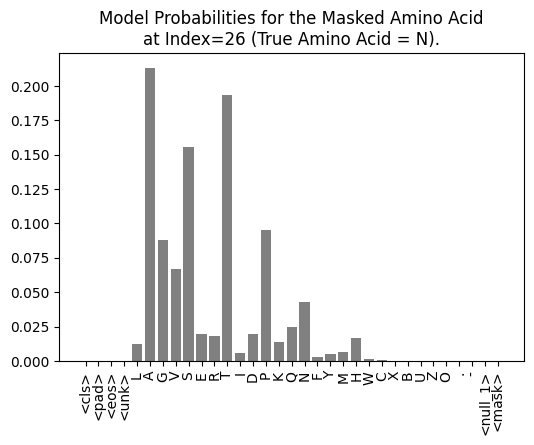

In [24]:
MaskPredictor(tokenizer, model=masked_lm_model).plot_predictions(
  sequence=insulin_sequence, mask_index=26
);

It assigns moderate probability to several possible amino acids, indicating that this position is harder to predict based on surrounding context. In other words, this also implies a certain extent of biochemical flexibility in this position.

### 2.3.5. Strategies for Extracting an Embedding for an Entire Protein
### 2.3.6. Extracellular Versus Membrane Protein Embeddings


In [25]:
import pandas as pd

from dlfb.utils.context import assets

protein_df = pd.read_csv(assets("proteins/datasets/sequence_df_cco.csv"))
protein_df = protein_df[~protein_df["term"].isin(["GO:0005575", "GO:0110165"])]
num_proteins = protein_df["EntryID"].nunique()
print(protein_df)

       EntryID                                           Sequence  taxonomyID  \
0       O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...        9606   
1       O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...        9606   
2       O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...        9606   
3       O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...        9606   
5       O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...        9606   
...        ...                                                ...         ...   
337549  E7ER32  MPPLKSPAAFHEQRRSLERARTEDYLKRKIRSRPERSELVRMHILE...        9606   
337550  E7ER32  MPPLKSPAAFHEQRRSLERARTEDYLKRKIRSRPERSELVRMHILE...        9606   
337551  E7ER32  MPPLKSPAAFHEQRRSLERARTEDYLKRKIRSRPERSELVRMHILE...        9606   
337552  E7ER32  MPPLKSPAAFHEQRRSLERARTEDYLKRKIRSRPERSELVRMHILE...        9606   
337553  E7ER32  MPPLKSPAAFHEQRRSLERARTEDYLKRKIRSRPERSELVRMHILE...        9606   

              term aspect  

The GO term refers to protein location. We filter the data accordingly.

In [26]:
# Filter protein dataframe to proteins with a single location.
num_locations = protein_df.groupby("EntryID")["term"].nunique()
proteins_one_location = num_locations[num_locations == 1].index
protein_df = protein_df[protein_df["EntryID"].isin(proteins_one_location)]

go_function_examples = {
  "extracellular": "GO:0005576",
  "membrane": "GO:0016020",
}

sequences_by_function = {}

min_length = 100
max_length = 500  # Cap sequence length for speed and memory.
num_samples = 20

for function, go_term in go_function_examples.items():
  proteins_with_function = protein_df[
    (protein_df["term"] == go_term)
    & (protein_df["Length"] >= min_length)
    & (protein_df["Length"] <= max_length)
  ]
  print(
    f"Found {len(proteins_with_function)} human proteins\n"
    f"with the molecular function '{function}' ({go_term}),\n"
    f"and {min_length}<=length<={max_length}.\n"
    f"Sampling {num_samples} proteins at random.\n"
  )
  sequences = list(
    proteins_with_function.sample(num_samples, random_state=42)["Sequence"]
  )
  sequences_by_function[function] = sequences

Found 164 human proteins
with the molecular function 'extracellular' (GO:0005576),
and 100<=length<=500.
Sampling 20 proteins at random.

Found 65 human proteins
with the molecular function 'membrane' (GO:0016020),
and 100<=length<=500.
Sampling 20 proteins at random.



#### Mean contextual embeddings

In [27]:
from dlfb.proteins.dataset import get_mean_embeddings

display([get_mean_embeddings])

def get_mean_embeddings(
  sequences: list[str],
  tokenizer: PreTrainedTokenizer,
  model: PreTrainedModel,
  device: torch.device | None = None,
) -> np.ndarray:
  """Compute mean embedding for each sequence using a protein LM."""
  if not device:
    device = get_device()

  # Tokenize input sequences and pad them to equal length.
  model_inputs = tokenizer(sequences, padding=True, return_tensors="pt")

  # Move tokenized inputs to the target device (CPU or GPU).
  model_inputs = {k: v.to(device) for k, v in model_inputs.items()}

  # Move model to the target device and set it to evaluation mode.
  model = model.to(device)
  model.eval()

  # Forward pass without gradient tracking to obtain embeddings.
  with torch.no_grad():
    outputs = model(**model_inputs)
    mean_embeddings = outputs.last_hidden_state.mean(dim=1)

  return mean_embeddings.detach().cpu().numpy()

In [28]:
model_checkpoint = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = EsmModel.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# Compute mean protein embeddings for each location.
protein_embeddings = {
  loc: get_mean_embeddings(sequences_by_function[loc], tokenizer, model)
  for loc in ["extracellular", "membrane"]
}

# Reformat data.
labels, embeddings = [], []
for location, embedding in protein_embeddings.items():
  labels.extend([location] * embedding.shape[0])
  embeddings.append(embedding)
  print(f"{location}: {embedding.shape}")

extracellular: (20, 320)
membrane: (20, 320)


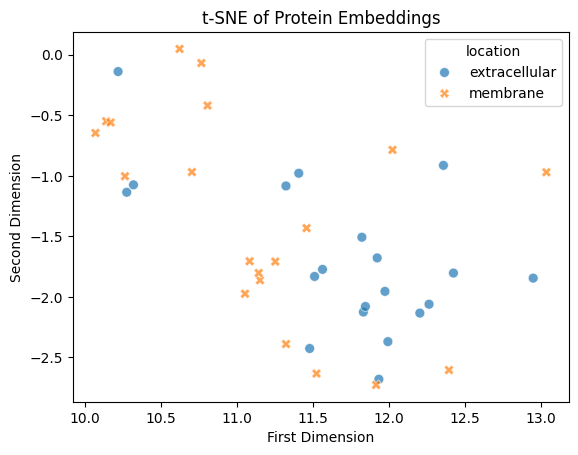

In [32]:
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE

embeddings_tsne = TSNE(n_components=2, random_state=42).fit_transform(
  np.vstack(embeddings)
)
embeddings_tsne_df = pd.DataFrame(
  {
    "first_dimension": embeddings_tsne[:, 0],
    "second_dimension": embeddings_tsne[:, 1],
    "location": np.array(labels),
  }
)

fig = sns.scatterplot(
  data=embeddings_tsne_df,
  x="first_dimension",
  y="second_dimension",
  hue="location",
  style="location",
  s=50,
  alpha=0.7,
)
plt.title("t-SNE of Protein Embeddings")
fig.set_xlabel("First Dimension")
fig.set_ylabel("Second Dimension");

In [ ]:
# import matplotlib.pyplot as plt
# import pandas as pd
# from transformers import AutoTokenizer, EsmModel

# from dlfb.utils.context import assets

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2.4. Preparing the Data
### 2.4.1. Loading the CAFA3 Data


biological process (BPO), molecular function (MFO), and cellular component (CCO)

In [29]:
labels = pd.read_csv(
  assets("proteins/datasets/train_terms.tsv.zip"), sep="\t", compression="infer"
)
print(labels)

            EntryID        term aspect
0        A0A009IHW8  GO:0008152    BPO
1        A0A009IHW8  GO:0034655    BPO
2        A0A009IHW8  GO:0072523    BPO
3        A0A009IHW8  GO:0044270    BPO
4        A0A009IHW8  GO:0006753    BPO
...             ...         ...    ...
5363858      X5L565  GO:0050649    MFO
5363859      X5L565  GO:0016491    MFO
5363860      X5M5N0  GO:0005515    MFO
5363861      X5M5N0  GO:0005488    MFO
5363862      X5M5N0  GO:0003674    MFO

[5363863 rows x 3 columns]


Get the description of GO terms and merge it to the dataset

In [30]:
from dlfb.proteins.dataset import get_go_term_descriptions

display(["import obonet", get_go_term_descriptions])

import obonet

def get_go_term_descriptions(store_path: str) -> pd.DataFrame:
  """Return GO term to description mapping, downloading if needed."""
  if not os.path.exists(store_path):
    url = "https://current.geneontology.org/ontology/go-basic.obo"
    graph = obonet.read_obo(url)

    # Extract GO term IDs and names from the graph nodes.
    id_to_name = {id: data.get("name") for id, data in graph.nodes(data=True)}
    go_term_descriptions = pd.DataFrame(
      zip(id_to_name.keys(), id_to_name.values()),
      columns=["term", "description"],
    )
    go_term_descriptions.to_csv(store_path, index=False)

  else:
    go_term_descriptions = pd.read_csv(store_path)
  return go_term_descriptions

In [31]:
go_term_descriptions = get_go_term_descriptions(
  store_path=assets("proteins/datasets/go_term_descriptions.csv")
)
print(go_term_descriptions)

             term                                        description
0      GO:0000001                          mitochondrion inheritance
1      GO:0000002                   mitochondrial genome maintenance
2      GO:0000006  high-affinity zinc transmembrane transporter a...
3      GO:0000007  low-affinity zinc ion transmembrane transporte...
4      GO:0000009             alpha-1,6-mannosyltransferase activity
...           ...                                                ...
40209  GO:2001313  UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...
40210  GO:2001314  UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...
40211  GO:2001315  UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...
40212  GO:2001316                       kojic acid metabolic process
40213  GO:2001317                    kojic acid biosynthetic process

[40214 rows x 2 columns]


In [32]:
labels = labels.merge(go_term_descriptions, on="term")
print(labels)

            EntryID        term aspect  \
0        A0A009IHW8  GO:0008152    BPO   
1        A0A009IHW8  GO:0034655    BPO   
2        A0A009IHW8  GO:0072523    BPO   
3        A0A009IHW8  GO:0006753    BPO   
4        A0A009IHW8  GO:1901292    BPO   
...             ...         ...    ...   
4933953      X5L565  GO:0050649    MFO   
4933954      X5L565  GO:0016491    MFO   
4933955      X5M5N0  GO:0005515    MFO   
4933956      X5M5N0  GO:0005488    MFO   
4933957      X5M5N0  GO:0003674    MFO   

                                              description  
0                                       metabolic process  
1        nucleobase-containing compound catabolic process  
2            purine-containing compound catabolic process  
3                  nucleoside phosphate metabolic process  
4                  nucleoside phosphate catabolic process  
...                                                   ...  
4933953          testosterone 6-beta-hydroxylase activity  
4933954        

In [33]:
labels = labels[labels["aspect"] == "MFO"] # focus only on molecular function
print(labels["description"].value_counts())

description
molecular_function                                78637
binding                                           57380
protein binding                                   47987
catalytic activity                                25324
heterocyclic compound binding                     12694
                                                  ...  
lovastatin nonaketide synthase activity               1
histone H3K37 methyltransferase activity              1
mitochondrion-plasma membrane adaptor activity        1
phenylacetate 2-hydroxylase activity                  1
NAD-dependent protein biotinidase activity            1
Name: count, Length: 6973, dtype: int64


Load in protein sequence information (.fasta)

In [34]:
from Bio import SeqIO

sequences_file = assets("proteins/datasets/train_sequences.fasta")
fasta_sequences = SeqIO.parse(open(sequences_file), "fasta")

data = []
for fasta in fasta_sequences:
  data.append(
    {
      "EntryID": fasta.id,
      "Sequence": str(fasta.seq),
      "Length": len(fasta.seq),
    }
  )
sequence_df = pd.DataFrame(data)
print(sequence_df)

           EntryID                                           Sequence  Length
0           P20536  MNSVTVSHAPYTITYHDDWEPVMSQLVEFYNEVASWLLRDETSPIP...     218
1           O73864  MTEYRNFLLLFITSLSVIYPCTGISWLGLTINGSSVGWNQTHHCKL...     354
2           O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...     258
3       A0A0B4J1F4  MGGEAGADGPRGRVKSLGLVFEDESKGCYSSGETVAGHVLLEAAEP...     415
4           P54366  MVETNSPPAGYTLKRSPSDLGEQQQPPRQISRSPGNTAAYHLTTAM...     415
...            ...                                                ...     ...
142241  A0A286YAI0  METEVDDFPGKASIFSQVNPLYSNNMKLCEAERYDFQHSEPKTMKS...     450
142242  A0A1D5NUC4  MSAAASAEMIETPPVLNFEEIDYKEIEVEEVVGRGAFGVVCKAKWR...     643
142243      Q5RGB0  MADKGPILTSVIIFYLSIGAAIFQILEEPNLNSAVDDYKNKTNNLL...     448
142244  A0A2R8QMZ5  MGRKKIQITRIMDERNRQVTFTKRKFGLMKKAYELSVLCDCEIALI...     459
142245  A0A8I6GHU0  HCISSLKLTAFFKRSFLLSPEKHLVLLRDGRTLIGFLRSIDQFANL...     138

[142246 rows x 3 columns]


Load in species information as well

In [35]:
taxonomy_file = assets("proteins/datasets/train_taxonomy.tsv.zip")
taxonomy = pd.read_csv(taxonomy_file, sep="\t", compression="infer")
print(taxonomy)

           EntryID  taxonomyID
0           Q8IXT2        9606
1           Q04418      559292
2           A8DYA3        7227
3           Q9UUI3      284812
4           Q57ZS4      185431
...            ...         ...
142241      Q5TD07        9606
142242      A8BB17        7955
142243  A0A2R8QBB1        7955
142244      P0CT72      284812
142245      Q9NZ43        9606

[142246 rows x 2 columns]


Keep only human protein sequences

In [36]:
sequence_df = sequence_df.merge(taxonomy, on="EntryID")
sequence_df = sequence_df[sequence_df["taxonomyID"] == 9606]

In [37]:
sequence_df = sequence_df.merge(labels, on="EntryID")
print(
  f'Dataset contains {sequence_df["EntryID"].nunique()} human proteins '
  f'with {sequence_df["term"].nunique()} molecular functions.'
)

Dataset contains 16336 human proteins with 4101 molecular functions.


In [38]:
print(sequence_df)

       EntryID                                           Sequence  Length  \
0       O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...     258   
1       O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...     258   
2       O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...     258   
3       O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...     258   
4       O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...     258   
...        ...                                                ...     ...   
152521  Q549H9  MMEVESSYSDFISCDRTGRRNAVPDIQGDSEAVSVRKLAGDMGELA...      76   
152522  Q549H9  MMEVESSYSDFISCDRTGRRNAVPDIQGDSEAVSVRKLAGDMGELA...      76   
152523  Q86TI6  MGAAAVRWHLCVLLALGTRGRLAGGSGLPGSVDVDECSEGTDDCHI...     347   
152524  Q86TI6  MGAAAVRWHLCVLLALGTRGRLAGGSGLPGSVDVDECSEGTDDCHI...     347   
152525  Q86TI6  MGAAAVRWHLCVLLALGTRGRLAGGSGLPGSVDVDECSEGTDDCHI...     347   

        taxonomyID        term aspect  \
0             9606  GO:0003676    

Each protein (EntryID) links to multiple MFO terms

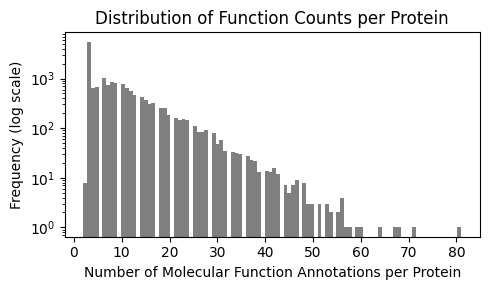

In [39]:
sequence_df.groupby("EntryID")["term"].nunique().plot.hist(
  bins=100, figsize=(5, 3), color="grey", log=True
)
plt.xlabel("Number of Molecular Function Annotations per Protein")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of Function Counts per Protein")
plt.tight_layout()

Some terms are so broad and universally assigned that they offer little meaningful insight. For example, molecular function applies to nearly all proteins, binding covers 93%, and protein binding appears in 89% of cases. These labels will tend to dominate the loss during training and can cause the model to fixate on predicting them at the expense of more meaningful functions. As a dataset preprocessing step, we’ll explicitly remove these overly generic terms:

In [40]:
uninteresting_functions = [
  "GO:0003674",  # "molecular function". Applies to 100% of proteins.
  "GO:0005488",  # "binding". Applies to 93% of proteins.
  "GO:0005515",  # "protein binding". Applies to 89% of proteins.
]

sequence_df = sequence_df[~sequence_df["term"].isin(uninteresting_functions)]
sequence_df.shape

(106501, 7)

We also filter out the rarest labels and keep only those that appear in at least 50 proteins, so that the model learns meaningful information with sufficient number of data.

In [41]:
common_functions = (
  sequence_df["term"]
  .value_counts()[sequence_df["term"].value_counts() >= 50]
  .index
)

sequence_df = sequence_df[sequence_df["term"].isin(common_functions)]
sequence_df["term"].value_counts()

,count
term,
GO:0003824,3875
GO:1901363,2943
GO:0003676,2469
GO:0042802,1803
GO:0016740,1652
...,...
GO:0005230,52
GO:0031490,51
GO:0005516,51


Assemble a dataframe with one-hot table of GO terms.

In [42]:
sequence_df = (
  sequence_df[["EntryID", "Sequence", "Length", "term"]]
  .assign(value=1)
  .pivot(
    index=["EntryID", "Sequence", "Length"], columns="term", values="value"
  )
  .fillna(0)
  .astype(int)
  .reset_index()
)
print(sequence_df)

term      EntryID                                           Sequence  Length  \
0      A0A024R6B2  MIASCLCYLLLPATRLFRALSDAFFTCRKNVLLANSSSPQVEGDFA...     670   
1      A0A087WUI6  MSRKISKESKKVNISSSLESEDISLETTVPTDDISSSEEREGKVRI...     698   
2      A0A087X1C5  MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...     515   
3      A0A0C4DG62  MAHVGSRKRSRSRSRSRGRGSEKRKKKSRKDTSRNCSASTSQERSK...     218   
4      A0A0C4DGF1  MSLPPIRLPSPYGSDRLVQLAARLRPALCDTLITVGSQEFPAHSLV...     302   
...           ...                                                ...     ...   
10704      Q9Y6Y8  MAERKPNGGSGGASTSSSGTNLLFSSSATEFSFNVPFIPVTQASAS...    1000   
10705      Q9Y6Y9  MLPFLFFSTLFSSIFTEAQKQYWVCNSSDASISYTYCDKMQYPISI...     160   
10706      Q9Y6Z7  MNGFASLLRRNQFILLVLFLLQIQSLGLDIDSRPTAEVCATHTISP...     277   
10707      X5D778  MPKGGCPKAPQQEELPLSSDMVEKQTGKKDKDKVSLTKTPKLERGD...     421   
10708      X5D7E3  MLDLTSRGQVGTSRRMAEAACSAHFLETTPTPNPPTTEEEKTESNQ...     237   

term   GO:0000166  GO:0000287  GO:00009

In [43]:
sequence_df["EntryID"].nunique()

10709

In [44]:
sequence_df["Sequence"].nunique()

10698

Seems that there are some protein duplicates (Different ID, same sequence)

In [45]:
print(sequence_df[sequence_df["EntryID"].isin(["P0DP23", "P0DP24", "P0DP25"])])

term EntryID                                           Sequence  Length  \
1945  P0DP23  MADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTE...     149   
1946  P0DP24  MADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTE...     149   
1947  P0DP25  MADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTE...     149   

term  GO:0000166  GO:0000287  GO:0000976  GO:0000977  GO:0000978  GO:0000981  \
1945           0           0           0           0           0           0   
1946           0           0           0           0           0           0   
1947           0           0           0           0           0           0   

term  GO:0000987  ...  GO:0140677  GO:0140678  GO:1901265  GO:1901363  \
1945           0  ...           1           1           0           0   
1946           0  ...           1           1           0           0   
1947           0  ...           1           0           0           0   

term  GO:1901681  GO:1901702  GO:1901981  GO:1902936  GO:1990782  GO:1990837  
1945  

To maintain computational performance, do the training only with maximal seq length 500 aa.

In [46]:
print(sequence_df.shape)
sequence_df = sequence_df[sequence_df["Length"] <= 500]
print(sequence_df.shape)

(10709, 306)
(5957, 306)


### 2.4.2. Splitting the Dataset into Subsets


We split the dataset as 60% training, 20% validation, 20% testing set.

In [47]:
from sklearn.model_selection import train_test_split

# 60% of the proteins will go into the training set.
train_sequence_ids, valid_test_sequence_ids = train_test_split(
  list(set(sequence_df["EntryID"])), test_size=0.40, random_state=42
)

# Split the remaining 40% evenly between validation and test sets.
valid_sequence_ids, test_sequence_ids = train_test_split(
  valid_test_sequence_ids, test_size=0.50, random_state=42
)

In [48]:
sequence_splits = {
  "train": sequence_df[sequence_df["EntryID"].isin(train_sequence_ids)],
  "valid": sequence_df[sequence_df["EntryID"].isin(valid_sequence_ids)],
  "test": sequence_df[sequence_df["EntryID"].isin(test_sequence_ids)],
}

for split, df in sequence_splits.items():
  print(f"{split} has {len(df)} entries.")

train has 3574 entries.
valid has 1191 entries.
test has 1192 entries.


### 2.4.3. Converting Protein Sequences into Their Mean Embeddings


In [49]:
from dlfb.proteins.dataset import (
  load_sequence_embeddings,
  store_sequence_embeddings,
)

display([store_sequence_embeddings, load_sequence_embeddings])

def store_sequence_embeddings(
  sequence_df: pd.DataFrame,
  store_prefix: str,
  tokenizer: PreTrainedTokenizer,
  model: PreTrainedModel,
  batch_size: int = 64,
  force: bool = False,
) -> None:
  """Extract and store mean embeddings for each protein sequence."""
  model_name = str(model.name_or_path).replace("/", "_")
  store_file = f"{store_prefix}_{model_name}.feather"

  if not os.path.exists(store_file) or force:
    device = get_device()

    # Iterate through protein dataframe in batches, extracting embeddings.
    n_batches = ceil(sequence_df.shape[0] / batch_size)
    batches: list[np.ndarray] = []
    for i in range(n_batches):
      batch_seqs = list(
        sequence_df["Sequence"][i * batch_size : (i + 1) * batch_size]
      )
      batches.extend(get_mean_embeddings(batch_seqs, tokenizer, model, device))

    # Store each of the embedding values in a separate column in the dataframe.
    embeddings = pd.DataFrame(np.vstack(batches))
    embeddings.columns = [f"ME:{int(i)+1}" for i in range(embeddings.shape[1])]
    df = pd.concat([sequence_df.reset_index(drop=True), embeddings], axis=1)
    df.to_feather(store_file)


def load_sequence_embeddings(
  store_file_prefix: str, model_checkpoint: str
) -> pd.DataFrame:
  """Load stored embedding DataFrame from disk."""
  model_name = model_checkpoint.replace("/", "_")
  store_file = f"{store_file_prefix}_{model_name}.feather"
  return pd.read_feather(store_file)

In [50]:
model_checkpoint = "facebook/esm2_t30_150M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = EsmModel.from_pretrained(model_checkpoint)

for split, df in sequence_splits.items():
  store_sequence_embeddings(
    sequence_df=df,
    store_prefix=assets(f"proteins/datasets/protein_dataset_{split}"),
    tokenizer=tokenizer,
    model=model,
  )

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
train_df = load_sequence_embeddings(
  assets("proteins/datasets/protein_dataset_train"),
  model_checkpoint=model_checkpoint,
)

print(train_df)

         EntryID                                           Sequence  Length  \
0     A0A0C4DG62  MAHVGSRKRSRSRSRSRGRGSEKRKKKSRKDTSRNCSASTSQERSK...     218   
1     A0A1B0GTB2   MVITSENDEDRGGQEKESKEESVLAMLGIIGTILNLIVIIFVYIYTTL      48   
2         A0AVI4  MDSPEVTFTLAYLVFAVCFVFTPNEFHAAGLTVQNLLSGWLGSEDA...     362   
3         A0PJW6  MAAPWRRWPTGLLAVLRPLLTCRPLQGTTLQRDVLLFEHDRGRFFT...     202   
4         A1L167  MKELQDIARLSDRFISVELVDESLFDWNVKLHQVDKDSVLWQDMKE...     161   
...          ...                                                ...     ...   
3569      Q9Y6N5  MVPLVAVVSGPRAQLFACLLRLGTQQVGPLQLHTGASHAARNHYEV...     450   
3570      Q9Y6P5  MRLAAAANEAYTAPLAVSGLLGCKQCGGGRDQDEELGIRIPRPLGQ...     492   
3571      Q9Y6W5  MPLVTRNIEPRHLCRQTLPSVRSELECVTNITLANVIRQLGSLSKY...     498   
3572      Q9Y6W6  MPPSPLDDRVVVALSRPVRPQDLNLCLDSSYLGSANPGSNSHPPVI...     482   
3573      Q9Y6Y9  MLPFLFFSTLFSSIFTEAQKQYWVCNSSDASISYTYCDKMQYPISI...     160   

      GO:0000166  GO:0000287  GO:0000976  GO:000097

Convert the datatype for later tensorflow training

In [52]:
from dlfb.proteins.dataset import convert_to_tfds

display(["import tensorflow as tf", convert_to_tfds])

import tensorflow as tf

def convert_to_tfds(
  df: pd.DataFrame,
  embeddings_prefix: str = "ME:",
  target_prefix: str = "GO:",
  is_training: bool = False,
  shuffle_buffer: int = 50,
) -> tf.data.Dataset:
  """Convert embedding DataFrame into a TensorFlow dataset."""
  dataset = tf.data.Dataset.from_tensor_slices(
    {
      "embedding": df.filter(regex=f"^{embeddings_prefix}").to_numpy(),
      "target": df.filter(regex=f"^{target_prefix}").to_numpy(),
    }
  )
  if is_training:
    dataset = dataset.shuffle(shuffle_buffer).repeat()
  return dataset

In [59]:
train_ds = convert_to_tfds(train_df, is_training=True)
# the is_training flag enables shuffling and repeating the dataset for training
# for validation and test sets, set is_training=False

Create a numpy iterator of batch size 32

In [ ]:
batch_size = 32

batch = next(train_ds.batch(batch_size).as_numpy_iterator())
batch["embedding"].shape, batch["target"].shape

((32, 640), (32, 303))

In [60]:
from dlfb.proteins.dataset import build_dataset

display([build_dataset])

def build_dataset(
  store_file_prefix: str, model_checkpoint: str
) -> dict[str, tf.data.Dataset]:
  """Build train/valid/test TensorFlow datasets from stored embeddings."""
  dataset_splits = {}

  for split in ["train", "valid", "test"]:
    dataset_splits[split] = convert_to_tfds(
      df=load_sequence_embeddings(
        store_file_prefix=f"{store_file_prefix}_{split}",
        model_checkpoint=model_checkpoint,
      ),
      is_training=(split == "train"),
    )
  return dataset_splits

In [61]:
dataset_splits = build_dataset(
  assets("proteins/datasets/protein_dataset"), model_checkpoint=model_checkpoint
)

In [62]:
import jax
import numpy as np
import pandas as pd

from dlfb.proteins.dataset import (
  build_dataset,
  get_go_term_descriptions,
  load_sequence_embeddings,
)
from dlfb.utils.context import assets

go_term_descriptions = get_go_term_descriptions(
  store_path=assets("proteins/datasets/go_term_descriptions.csv")
)

model_checkpoint = "facebook/esm2_t30_150M_UR50D"

train_df = load_sequence_embeddings(
  store_file_prefix=f"{assets('proteins/datasets/protein_dataset')}_train",
  model_checkpoint=model_checkpoint,
)

dataset_splits = build_dataset(
  assets("proteins/datasets/protein_dataset"), model_checkpoint=model_checkpoint
)
batch = next(dataset_splits["train"].as_numpy_iterator())

## 2.5. Training the Model


We will now train a simple Flax linear model on top of the mean protein embeddings. Recall that each protein sequence has a variable length, but we’ve already transformed them into fixed-size embeddings. Our goal is to predict which of the 303 possible molecular functions each protein performs. This is a multilabel classification problem, meaning each protein may be associated with several function labels simultaneously. In this setup, we’ll train a **lightweight MLP (multilayer perceptron)**—a stack of dense layers with nonlinearities. Importantly, we are not fine-tuning the original ESM2 model: it remains frozen, and our model simply learns on top of its embeddings.

MLP model:
- input (640 features) -> 512 (Gelu) -> 256 (Gelu) -> 303 (num_target) -> output (logit)

In [63]:
from dlfb.proteins.model import Model

display(
  ["import flax.linen as nn\nfrom flax.training import train_state\n", Model]
)

import flax.linen as nn
from flax.training import train_state


class Model(nn.Module):
  """Simple MLP for protein function prediction."""

  num_targets: int
  dim: int = 256

  @nn.compact
  def __call__(self, x):
    """Apply MLP layers to input features."""
    x = nn.Sequential(
      [
        nn.Dense(self.dim * 2),
        jax.nn.gelu,
        nn.Dense(self.dim),
        jax.nn.gelu,
        nn.Dense(self.num_targets),
      ]
    )(x)
    return x

  def create_train_state(self, rng: jax.Array, dummy_input, tx) -> TrainState:
    """Initialize model parameters and return a training state."""
    variables = self.init(rng, dummy_input)
    return TrainState.create(
      apply_fn=self.apply, params=variables["params"], tx=tx
    )

In [65]:
targets = list(train_df.columns[train_df.columns.str.contains("GO:")])

mlp = Model(num_targets=len(targets))

### 2.5.1. Defining the Training Loop


In [ ]:
from dlfb.proteins.train import train_step

display([train_step])

@jax.jit
def train_step(state, batch):
  """Run a single training step and update model parameters."""

  def calculate_loss(params):
    """Compute sigmoid cross-entropy loss from logits."""
    logits = state.apply_fn({"params": params}, x=batch["embedding"])
    loss = optax.sigmoid_binary_cross_entropy(logits, batch["target"]).mean()
    return loss

  grad_fn = jax.value_and_grad(calculate_loss, has_aux=False)
  loss, grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state, loss

We use a **sigmoid activation and binary cross-entropy loss**, appropriate for multilabel classification. The logits go through a sigmoid activation, not softmax—because we want independent yes/no predictions for each possible protein function. Remember that each protein could have many functions at once.

In [67]:
from dlfb.proteins.train import compute_metrics

display(["import sklearn", compute_metrics])

import sklearn

def compute_metrics(
  targets: np.ndarray, probs: np.ndarray, thresh=0.5
) -> dict[str, float]:
  """Compute accuracy, recall, precision, auPRC, and auROC."""
  if np.sum(targets) == 0:
    return {
      m: 0.0 for m in ["accuracy", "recall", "precision", "auprc", "auroc"]
    }
  return {
    "accuracy": metrics.accuracy_score(targets, probs >= thresh),
    "recall": metrics.recall_score(targets, probs >= thresh).item(),
    "precision": metrics.precision_score(
      targets,
      probs >= thresh,
      zero_division=0.0,
    ).item(),
    "auprc": metrics.average_precision_score(targets, probs).item(),
    "auroc": metrics.roc_auc_score(targets, probs).item(),
  }

In [68]:
from dlfb.proteins.train import calculate_per_target_metrics, eval_step

display([eval_step, calculate_per_target_metrics])

def eval_step(state, batch) -> dict[str, float]:
  """Run evaluation step and return mean metrics over targets."""
  logits = state.apply_fn({"params": state.params}, x=batch["embedding"])
  loss = optax.sigmoid_binary_cross_entropy(logits, batch["target"]).mean()
  target_metrics = calculate_per_target_metrics(logits, batch["target"])
  metrics = {
    "loss": loss.item(),
    **pd.DataFrame(target_metrics).mean(axis=0).to_dict(),
  }
  return metrics


def calculate_per_target_metrics(logits, targets):
  """Compute metrics for each target in a multi-label batch."""
  probs = jax.nn.sigmoid(logits)
  target_metrics = []
  for target, prob in zip(targets, probs):
    target_metrics.append(compute_metrics(target, prob))
  return target_metrics

In a multilabel setting, we calculate these metrics for each protein function (i.e., per target/label), then average them to get a holistic view of model performance.

In [69]:
from dlfb.proteins.train import train

display([train])

def train(
  state: TrainState,
  dataset_splits: dict[str, tf.data.Dataset],
  batch_size: int,
  num_steps: int = 300,
  eval_every: int = 30,
):
  """Train model using batched TF datasets and track performance metrics."""
  # Create containers to handle calculated during training and evaluation.
  train_metrics, valid_metrics = [], []

  # Create batched dataset to pluck batches from for each step.
  train_batches = (
    dataset_splits["train"]
    .batch(batch_size, drop_remainder=True)
    .as_numpy_iterator()
  )

  steps = tqdm(range(num_steps))  # Steps with progress bar.
  for step in steps:
    steps.set_description(f"Step {step + 1}")

    # Get batch of training data, convert into a JAX array, and train.
    state, loss = train_step(state, next(train_batches))
    train_metrics.append({"step": step, "loss": loss.item()})

    if step % eval_every == 0:
      # For all the evaluation batches, calculate metrics.
      eval_metrics = []
      for eval_batch in (
        dataset_splits["valid"].batch(batch_size=batch_size).as_numpy_iterator()
      ):
        eval_metrics.append(eval_step(state, eval_batch))
      valid_metrics.append(
        {"step": step, **pd.DataFrame(eval_metrics).mean(axis=0).to_dict()}
      )

  return state, {"train": train_metrics, "valid": valid_metrics}

Evaluation is done per protein (average across multi-labels for one specific protein)

Every eval_every step, the model is evaluated on the full validation set to monitor progress using metrics we defined previously. Validation metrics are computed batch-wise and then averaged across all batches (entire dataset).

In [70]:
import optax

from dlfb.utils.restore import restorable

# Initiate training state with dummy data from a single batch.
rng = jax.random.PRNGKey(42)
rng, rng_init = jax.random.split(key=rng, num=2)

state, metrics = restorable(train)(
  state=mlp.create_train_state(
    rng=rng_init, dummy_input=batch["embedding"], tx=optax.adam(0.001)
  ),
  dataset_splits=dataset_splits,
  batch_size=32,
  num_steps=300,
  eval_every=30,
  store_path=assets("proteins/models/mlp"), # if MLP model exist, skip training, restore from disk
)

Some additional parameters worth mentioning are the optimizer (here, optax.adam) and the total number of training steps (num_steps). Given that we have 2,100 training examples and a batch size of 32, it will take about 66 steps for the model to see the entire training set once. Setting num_steps=300 means the model will see each training data point several times.

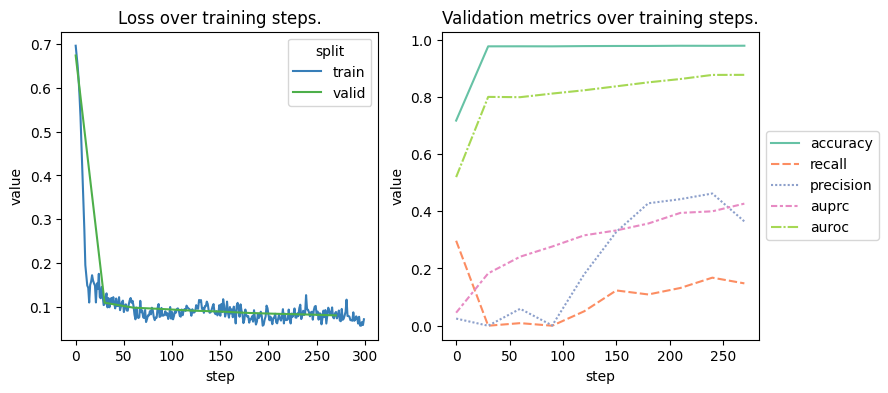

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

from dlfb.utils.metric_plots import DEFAULT_SPLIT_COLORS

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

# Plot training loss curve.
learning_data = pd.concat(
  pd.DataFrame(metrics[split]).melt("step").assign(split=split)
  for split in ["train", "valid"]
)

sns.lineplot(
  ax=ax[0],
  x="step",
  y="value",
  hue="split",
  data=learning_data[learning_data["variable"] == "loss"],
  palette=DEFAULT_SPLIT_COLORS,
)
ax[0].set_title("Loss over training steps.")

# Plot validation metrics curves.
sns.lineplot(
  ax=ax[1],
  x="step",
  y="value",
  hue="variable",
  style="variable",
  data=learning_data[learning_data["variable"] != "loss"],
  palette="Set2",
)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[1].set_title("Validation metrics over training steps.");

In the right panel, we track several evaluation metrics over time: 
- Accuracy and auROC start high and remain flat, but these can be misleading in imbalanced, multilabel settings like this one. Since most function labels are negative (i.e., a protein lacks the majority of all possible functions), a model that mostly predicts zeros can still achieve a high score on these metrics. For that reason, we don’t put much weight on these metrics in this context
- auPRC steadily improves and does not fully plateau, suggesting the model continues to learn subtle distinctions and could potentially benefit from further training (i.e., by increasing num_steps).
- Precision improves more quickly than recall, indicating the model becomes increasingly confident in its predictions but still fails to capture some true positives.

### 2.5.2. Examining the Model Predictions


With a trained model in hand, it’s time to explore its strengths and weaknesses. We’ll start by generating predictions for the entire validation set and storing them in a dataframe for easier inspection.

In [72]:
valid_df = load_sequence_embeddings(
  store_file_prefix=f"{assets('proteins/datasets/protein_dataset')}_valid",
  model_checkpoint=model_checkpoint,
)

# Use batch size of 1 to avoid dropping the remainder.
valid_probs = []
for valid_batch in dataset_splits["valid"].batch(1).as_numpy_iterator():
  logits = state.apply_fn({"params": state.params}, x=valid_batch["embedding"])
  valid_probs.extend(jax.nn.sigmoid(logits))

valid_true_df = valid_df[["EntryID"] + targets].set_index("EntryID")
valid_prob_df = pd.DataFrame(
  np.stack(valid_probs), columns=targets, index=valid_true_df.index
)

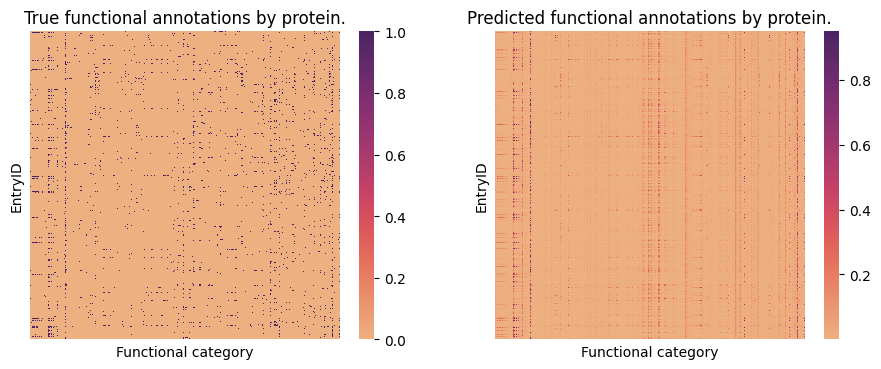

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))

sns.heatmap(
  ax=ax[0],
  data=valid_true_df,
  yticklabels=False,
  xticklabels=False,
  cmap="flare",
)
ax[0].set_title("True functional annotations by protein.")
ax[0].set_xlabel("Functional category")

sns.heatmap(
  ax=ax[1],
  data=valid_prob_df,
  yticklabels=False,
  xticklabels=False,
  cmap="flare",
)
ax[1].set_title("Predicted functional annotations by protein.")
ax[1].set_xlabel("Functional category");

- Some protein functions appear frequently in the dataset (visible as vertical stripes), and the model tends to predict these relatively well. 
- Rare functions are harder to capture—the model often misses them entirely, leading to sparse or empty columns in the predicted heatmap. 
- A few functions are over-predicted, visible as faint vertical lines across many proteins, suggesting the model is overly confident for those categories. 
- Many cells in the predicted matrix show intermediate color tones, which reflect more uncertain probabilities (not a confident near-0 or near-1).

In [74]:
metrics_by_function = {}
for function in targets:
  metrics_by_function[function] = compute_metrics(
    valid_true_df[function].values, valid_prob_df[function].values
  )

overview_valid = (
  pd.DataFrame(metrics_by_function)
  .T.merge(go_term_descriptions, left_index=True, right_on="term")
  .set_index("term")
  .sort_values("auprc", ascending=False)
)
print(overview_valid)

            accuracy    recall  precision     auprc     auroc  \
term                                                            
GO:0004930  0.958858  0.000000   0.000000  0.948591  0.982272   
GO:0004888  0.945424  0.177215   1.000000  0.849885  0.968354   
GO:0003824  0.848027  0.731591   0.819149  0.849362  0.909372   
GO:1990837  0.954660  0.543689   0.888889  0.825313  0.970820   
GO:0043565  0.955500  0.649123   0.850575  0.821888  0.963243   
...              ...       ...        ...       ...       ...   
GO:0004714  0.999160  0.000000   0.000000  0.001094  0.232773   
GO:0042626  0.000000  0.000000   0.000000  0.000000  0.000000   
GO:0051015  0.000000  0.000000   0.000000  0.000000  0.000000   
GO:0003774  0.000000  0.000000   0.000000  0.000000  0.000000   
GO:1902936  0.000000  0.000000   0.000000  0.000000  0.000000   

                                                  description  
term                                                           
GO:0004930                

In [75]:
# Compute number of occurences of each function in the training set.
overview_valid = overview_valid.merge(
  pd.DataFrame(train_df[targets].sum(), columns=["train_n"]),
  left_index=True,
  right_index=True,
)
print(overview_valid)

            accuracy    recall  precision     auprc     auroc  \
GO:0004930  0.958858  0.000000   0.000000  0.948591  0.982272   
GO:0004888  0.945424  0.177215   1.000000  0.849885  0.968354   
GO:0003824  0.848027  0.731591   0.819149  0.849362  0.909372   
GO:1990837  0.954660  0.543689   0.888889  0.825313  0.970820   
GO:0043565  0.955500  0.649123   0.850575  0.821888  0.963243   
...              ...       ...        ...       ...       ...   
GO:0004714  0.999160  0.000000   0.000000  0.001094  0.232773   
GO:0042626  0.000000  0.000000   0.000000  0.000000  0.000000   
GO:0051015  0.000000  0.000000   0.000000  0.000000  0.000000   
GO:0003774  0.000000  0.000000   0.000000  0.000000  0.000000   
GO:1902936  0.000000  0.000000   0.000000  0.000000  0.000000   

                                                  description  train_n  
GO:0004930                G protein-coupled receptor activity      138  
GO:0004888          transmembrane signaling receptor activity      228  


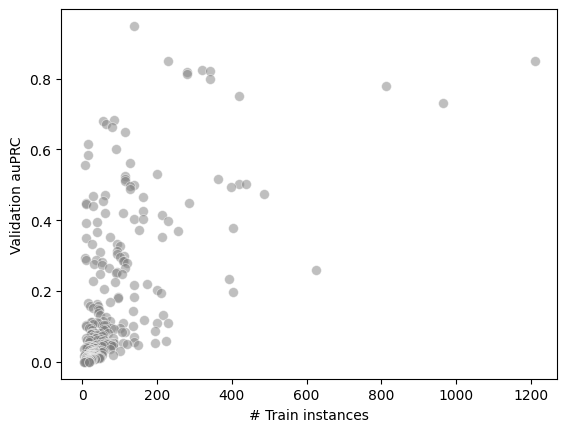

In [76]:
fig = sns.scatterplot(
  x="train_n", y="auprc", data=overview_valid, alpha=0.5, s=50, color="grey"
)
fig.set_xlabel("# Train instances")
fig.set_ylabel("Validation auPRC");

Protein functions that occur more frequently in the training set tend to be predicted more accurately by the model on the validation set (as measured by auPRC). This aligns with expectations—machine learning models usually perform better on well-represented classes. It also highlights the challenge of class imbalance: rare functions are often poorly predicted, not necessarily due to biological complexity but because the model has limited data to learn from.

### 2.5.3. Evaluating Model Usefulness


To ground our evaluation, we’ll compare our model against two simple baselines: 
- Coin flip: For each protein function, randomly predict 0 or 1 with equal probability. This gives us a baseline for total ignorance.
- Proportional guessing: Predict 1 for each function with probability equal to its frequency in the training set. This reflects prior class distribution knowledge, but without any learning.

In [77]:
def make_coin_flip_predictions(
  valid_true_df: pd.DataFrame, targets: list[str]
) -> pd.DataFrame:
  """Make random coin flip predictions for each protein function."""
  predictions = np.random.choice([0.0, 1.0], size=valid_true_df.shape)
  return pd.DataFrame(predictions, columns=targets, index=valid_true_df.index)


def make_proportional_predictions(
  valid_true_df: pd.DataFrame, train_df: pd.DataFrame, targets: list[str]
) -> pd.DataFrame:
  """Make random protein function predictions proportional to frequency."""
  percent_1_train = dict(train_df[targets].mean())
  proportional_preds = []
  for target_column in targets:
    prob_1 = percent_1_train[target_column]
    prob_0 = 1 - prob_1
    proportional_preds.append(
      np.random.choice([0.0, 1.0], size=len(valid_true_df), p=[prob_0, prob_1])
    )
  return pd.DataFrame(
    np.stack(proportional_preds).T, columns=targets, index=valid_true_df.index
  )

In [78]:
prediction_methods = {
  "coin_flip_baseline": make_coin_flip_predictions(valid_true_df, targets),
  "proportional_guess_baseline": make_proportional_predictions(
    valid_true_df, train_df, targets
  ),
  "model": valid_prob_df,
}

In [79]:
metrics_by_method = {}
for method, preds_df in prediction_methods.items():
  metrics_by_method[method] = pd.DataFrame(
    [
      compute_metrics(valid_true_df.iloc[i], preds_df.iloc[i])
      for i in range(len(valid_true_df))
    ]
  ).mean()

print(pd.DataFrame(metrics_by_method))

           coin_flip_baseline  proportional_guess_baseline     model
accuracy             0.499109                     0.956578  0.978569
recall               0.502855                     0.089369  0.128532
precision            0.023623                     0.081059  0.424301
auprc                0.025162                     0.038329  0.412350
auroc                0.500961                     0.533565  0.882679


Most of the model’s performance gains come from a large increase in precision, while the improvement in recall is more modest. This means the model is good at correctly identifying positive cases when it makes a prediction, but it tends to miss many true positives—it’s cautious and biased toward predicting “no function.”

This highlights a key trade-off: the model is conservative but accurate. Depending on your application, you may want to tune this behavior—for example, by lowering the decision threshold to improve recall, as discussed earlier.

In [80]:
auprc_by_function = {}

for method, preds_df in prediction_methods.items():
  metrics_by_function = {}

  for function in targets:
    metrics_by_function[function] = compute_metrics(
      valid_true_df[function], preds_df[function]
    )

  auprc_by_function[method] = (
    pd.DataFrame(metrics_by_function)
    .T.merge(go_term_descriptions, left_index=True, right_on="term")
    .set_index("term")
    .sort_values("auprc", ascending=False)
  )["auprc"].to_dict()

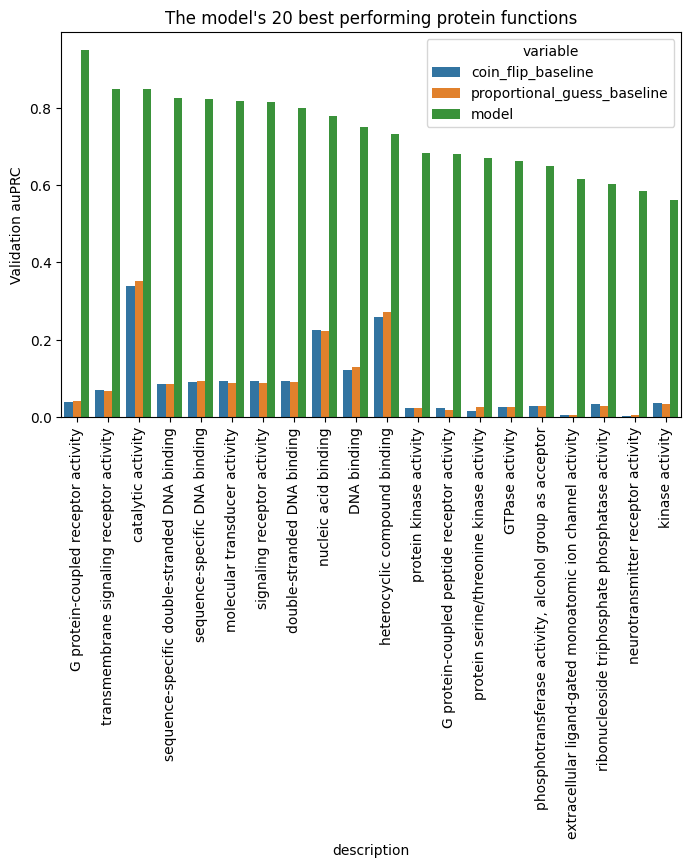

In [81]:
best_performing = (
  pd.DataFrame(auprc_by_function)
  .merge(go_term_descriptions, left_index=True, right_on="term")
  .set_index("term")
  .sort_values("model", ascending=False)
  .head(20)
  .melt("description")
)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
  x="description",
  y="value",
  hue="variable",
  data=best_performing,
)
ax.set_title("The model's 20 best performing protein functions")
ax.set_ylabel("Validation auPRC")
plt.xticks(rotation=90);

### 2.5.4. Conducting a Final Check on the Test Set


In [82]:
eval_metrics = []

for split in ["valid", "test"]:
  split_metrics = []

  for eval_batch in dataset_splits[split].batch(32).as_numpy_iterator():
    split_metrics.append(eval_step(state, eval_batch))

  eval_metrics.append(
    {"split": split, **pd.DataFrame(split_metrics).mean(axis=0).to_dict()}
  )
print(pd.DataFrame(eval_metrics))

   split      loss  accuracy    recall  precision     auprc     auroc
0  valid  0.080156  0.978457  0.126869   0.418515  0.411870  0.880883
1   test  0.080675  0.978032  0.125820   0.435193  0.410439  0.879234


## 2.6. Improvements and Extensions
### 2.6.1. Biological and Analytical Exploration
### 2.6.2. Machine Learning Improvements


## 2.7. Summary
